# Look at Enron data set

## Loading data
I load the original data. The data is provided as a dictionary. The keys are the names of the Enron employees.

In [4]:
import pickle
import numpy as np
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))
names = data_dict.keys()
features = []
labels = [item["poi"] for item in data_dict.values()]
for item in data_dict.values():
    new_item = {}
    for key, value in item.items():
        if key=="poi": continue
        if value == "NaN":
            new_item[key] = np.nan
        else:
            new_item[key] = value
    features.append(new_item)
names[:10]

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F']

## Basic data features
Number of samples:

In [5]:
len(names)

146

Number of persons of interest (POIs):

In [6]:
sum(labels)

18

Number of missing values per original feature:

In [7]:
import pandas as pd
data = pd.DataFrame(features, index=names)
data["poi"]=labels
def get_count_miss_vals(data):
    colnames = []
    n_miss = []
    for col in data.columns:
        if data[col].dtype == np.float_:
            colnames.append(col)
            n_miss.append(sum(np.isnan(data[col])))
    df=pd.DataFrame(n_miss, index=colnames, columns=["n_missing"]).sort_values(by="n_missing", ascending=False)
    df["non_miss"]=len(data)-df["n_missing"]
    return df

get_count_miss_vals(data)

,n_missing,non_miss
loan_advances,142,4
director_fees,129,17
restricted_stock_deferred,128,18
deferral_payments,107,39
deferred_income,97,49
long_term_incentive,80,66
bonus,64,82
from_poi_to_this_person,60,86
from_this_person_to_poi,60,86
from_messages,60,86


Number of persons of interest with missing values for respective feature

In [8]:
def get_n_pois_for_miss_vals(data):
    colnames = []
    n_pois = []
    for col in data.columns:
        if data[col].dtype == np.float_:
            colnames.append(col)
            n_pois.append(sum(data["poi"][np.isnan(data[col])]))
    return pd.DataFrame(n_pois, index=colnames, columns=["n_pois"]).sort_values(by="n_pois", ascending=False)
get_n_pois_for_miss_vals(data)

,n_pois
restricted_stock_deferred,18
director_fees,18
loan_advances,17
deferral_payments,13
deferred_income,7
exercised_stock_options,6
long_term_incentive,6
to_messages,4
from_messages,4
from_poi_to_this_person,4


## Data cleaning

`restricted_stock_deferred`, `director_fees` , `loan_advances`, `deferral_payments`, `deferred_income` are missing for more than 38% of all POIs. Therefore, the entries with missing values can not be disregarded, but the according features are not taken into account.

Since I want to construct features from the Enron email data set, I disregard entries with missing email data. This is the case of those datasets with `to_missing` feature missing.

In [9]:
data = data[np.isnan(data["to_messages"])==False]

Number of row with only missing values

In [10]:
nan_rows=pd.DataFrame()
for (rowidx, row) in data.drop('email_address',axis=1).iterrows():
    non_nan = False
    for colidx, col in enumerate(row):
        if not np.isnan(col):
            non_nan = True
            break
    if non_nan==False:
        nan_rows = nan_rows.append(row)
len(nan_rows)

0

Remaining samples

In [11]:
len(data)

86

Remaining POIs in sample

In [12]:
sum(data[data["poi"]==True]["poi"])

14

Portion of POIs:

In [13]:
sum(data[data["poi"]==True]["poi"])/float(len(data))

0.16279069767441862

### Outlier removal
There is a "TOTAL" data set in the data set which would have to be removed. Since there are no emails for "TOTAL" this data set is already removed by the previous selection criteria.

# Feature Enrichment
Since for the selected subset Enron emails are available, the according emails are processed. 

## Email text bag-of-words features
As it has been shown during the course, words in Emails can give a hint about the author of the respective email. I want to test, whether bag of words features are capable to discriminate between POIs and non-POIs.

At first, all words from emails from a given person are vectorized using the term-frequency times inverse document-frequency method after quoted emails are removed using regular expressions.

The maximum document frequency is set to 30% and the maximum number of features is set to 500 to reduce the number of features to handable size. 

## Subject features
Subject lines of emails sent or received by employees might also give a hint about their involvement in the Enron fraud case. Involved persons might have exchanged according mails.

To construct features from the subject lines, prefixes like "Re:" or "Fwd:" are stripped from subject lines.
Then, all subjects from emails from and to a given employee are vectorized separatly, such, that for a feature for each subject line is created. 

The maximum document frequency is set to 30% and the maximum number of features is set to 100 to reduce the number of features to handable size. 

## Set of features before training

The classifier will include feature selection steps that are trained on the training sample. The finally selected feature set can only be given after the training of the model. In this section all features used as input to the training of the classifier are given.

Financial features used

In [14]:
from poi_id import FEATURES_FINANCIAL
print "Number of financial features used:", len(FEATURES_FINANCIAL)
print "Names of  financial features used:"
FEATURES_FINANCIAL

Number of financial features used: 9
Names of  financial features used:


['salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock']

Count feautures from emails

In [15]:
from poi_id import FEATURES_EMAIL
print "Number of email count features used:", len(FEATURES_EMAIL)
print "Names of  email count features used:"
FEATURES_EMAIL

Number of email count features used: 5
Names of  email count features used:


['to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi']

Word features from emails sent by employees

In [16]:
# load prepared data with full feature set
from poi_id import prepare_data
full_data = prepare_data(None, load=True)
features = []
labels = []
names = []
for key, value in full_data.items():
    labels.append(value["poi"])
    value.pop("poi",None)
    features.append(value)
    names.append(key)

In [17]:
from poi_id import SelectMatchFeatures
words_selector = SelectMatchFeatures(feature_match="word_.*")
words_selector.fit_transform(features)
print "Number of word features:", len(words_selector.get_feature_names())
print "10 random word features"
print words_selector.get_feature_names()[0:10]

Number of word features: 500
10 random word features
[u'word_keith', u'word_barri', u'word_enjoy', u'word_delainey', u'word_buyer', u'word_obtain', u'word_recogn', u'word_adjust', u'word_swap', u'word_contain']


Subject features for emails sent by employees

In [18]:
subs_from_selector = SelectMatchFeatures(feature_match="sub_from_.*")
subs_from_selector.fit_transform(features)
print "Number of subjects from features:", len(subs_from_selector.get_feature_names())
print "10 random subjects from features"
print subs_from_selector.get_feature_names()[0:10]

Number of subjects from features: 100
10 random subjects from features
[u'sub_from_follow up', u'sub_from_hiring practices for summer interns', u'sub_from_cgas', u'sub_from_congrats', u'sub_from_presentation', u'sub_from_charts', u'sub_from_summer internship', u'sub_from_returned mail user unknown', u'sub_from_houston we have a problem', u'sub_from_organizational changes']


Subject features for emails sent to employees

In [19]:
subs_to_selector = SelectMatchFeatures(feature_match="sub_to_.*")
subs_to_selector.fit_transform(features)
print "Number of subjects to features:", len(subs_to_selector.get_feature_names())
print "10 random subjects to features"
print subs_to_selector.get_feature_names()[0:10]

Number of subjects to features: 100
10 random subjects to features
[u'sub_to_out of the office', u'sub_to_please note change midyear 2000 performance review process', u'sub_to_2000 ena offsite', u'sub_to_enrononline executive summary for december 7 2000', u'sub_to_netco', u'sub_to_enrononline executive summary  for june 04 2001', u'sub_to_ene friday peer group report', u'sub_to_px credits  schedule f in the pge bankruptcy', u'sub_to_enrononline executive summary for december 12 2000', u'sub_to_ena management committee']


Cross check for number of samples in prepared data set

In [20]:
len(labels)

86

In total, there are 714 features taken as input to the training.

## Feature overview

To get a first look a t the data, I construct a 2 dimensional representation of the data using a technique called [t-stochastic neighbor embedding](https://lvdmaaten.github.io/tsne/). To be able to do this I have to convert the dictionaries to vectors.

In [21]:
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE

tsne_viz = TSNE(n_components=2, random_state=42, perplexity=5, early_exaggeration=10).fit_transform(
    Imputer(strategy="median").fit_transform(
        DictVectorizer(sparse=False).fit_transform(features)))

In [22]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
output_notebook()

Loading BokehJS ...

In [23]:
from bokeh.palettes import RdBu3

names_Total = []
for name in names:
    names_Total.append(name)
source = ColumnDataSource(data=dict(x=tsne_viz[:,0],
                                    y=tsne_viz[:,1],
                                    names=names_Total,
                                    color=[RdBu3[label*2] for label in labels],
                                   ))
p = figure(plot_width=900, plot_height=500, active_scroll = "wheel_zoom")
p.circle(x="x", y="y", color="color", source=source, size=8)
plot_labels = LabelSet(x="x", y="y", text="names", source=source, level='glyph', render_mode='canvas')
p.add_layout(plot_labels)
show(p)

There are no clear patterns in this visualization.

Now, I want to look at some features of the data set.

In [24]:
#Convert NaN values using the feature transform classes developed
all_feature_selector = SelectMatchFeatures(convert_to_numeric=True, feature_match=".*")
data = pd.DataFrame(all_feature_selector.fit_transform(features), 
                    index=names,
                   columns=all_feature_selector.get_feature_names())
data["poi"]=labels
data

,word_keith,word_barri,word_enjoy,word_delainey,word_buyer,word_obtain,word_recogn,sub_from_follow up,word_adjust,word_swap,...,word_space,word_calger,sub_to_cpuc decision suspending direct access,sub_to_enrononline executive summary for december 5 2000,word_anticip,word_whalley,sub_to_what edison is saying,word_davi,sub_from_test,poi
METTS MARK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.368377,0.000000,0.340638,0.000000,0.000000,False
CORDES WILLIAM R,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.065488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
HANNON KEVIN P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
MEYER ROCKFORD G,0.000000,0.000000,0.000000,0.000000,0.000000,0.193917,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
MCMAHON JEFFREY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.148058,0.000000,0.000000,0.000000,0.000000,0.000000,False
HAEDICKE MARK E,0.009930,0.002365,0.012055,0.011309,0.010664,0.024559,0.000000,0.000000,0.005920,0.042978,...,0.005817,0.002548,0.081395,0.091621,0.014599,0.003878,0.086635,0.039304,0.166618,False
PIPER GREGORY F,0.000000,0.000000,0.000000,0.003951,0.000000,0.000000,0.003575,0.955283,0.003447,0.010726,...,0.010162,0.004451,0.000000,0.000000,0.000000,0.054196,0.000000,0.016157,0.000000,False
HUMPHREY GENE E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.059120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
BLACHMAN JEREMY M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.630575,0.000000,0.000000,0.000000,0.268468,0.000000,0.000000,False
SUNDE MARTIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.333533,0.000000,0.000000,0.000000,0.142002,0.000000,0.000000,False


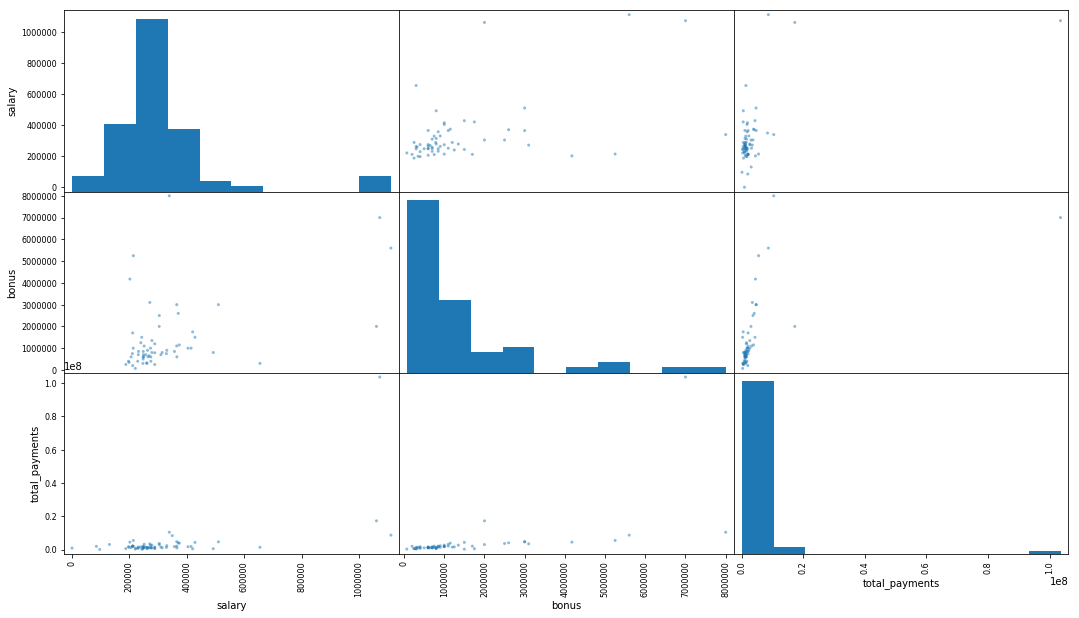

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
ax = scatter_matrix(data[["salary", "bonus", "total_payments"]], figsize=(18,10))

The data for all of this three variables is skewed. Depending on the method used a transformation to a logarithmic scale could be necessary.

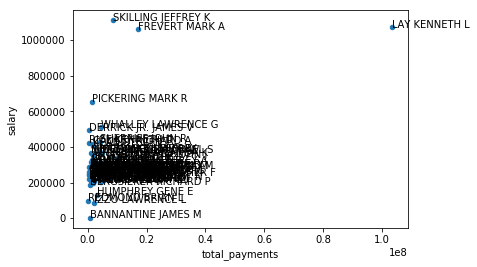

In [26]:
ax = data.plot.scatter(x="total_payments", y="salary")
def label_point(data, x, y, ax):
    for i, point in data.iterrows():
        if np.isnan(point[x]) or np.isnan(point[y]):
            continue
        else:
            #print \"x, y\", point[x], point[y]
            ax.text(point[x], point[y], i)
label_point(data, "total_payments", "salary", ax)
plt.draw()

Since the outlier is a real person involved in the case I do not remove it.

###  Email features

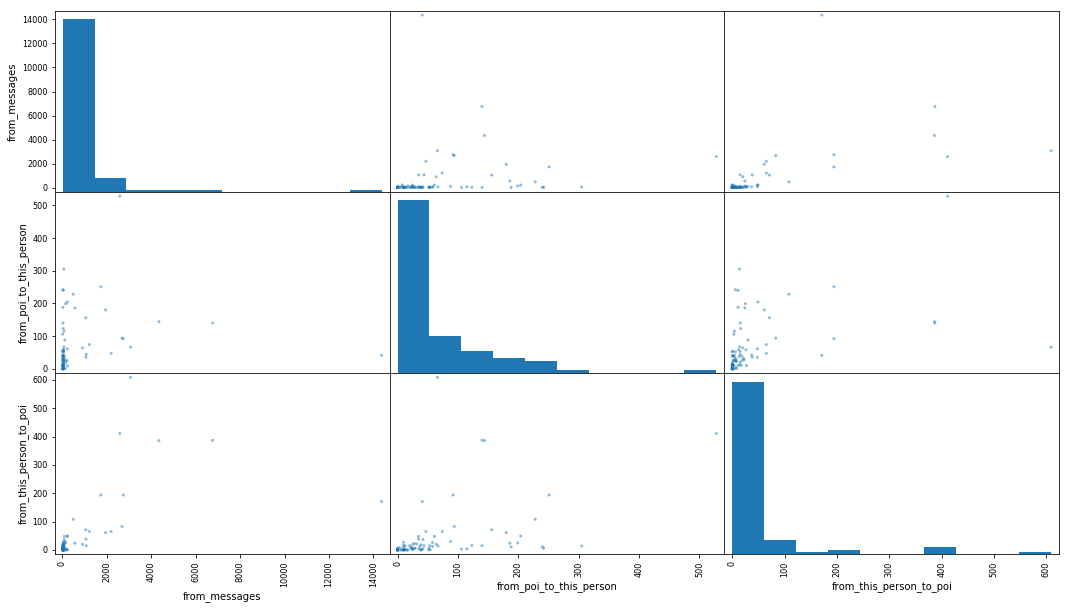

In [27]:
ax = scatter_matrix(data[["from_messages", "from_poi_to_this_person", "from_this_person_to_poi"]], figsize=(18,10))

Also these features' distributions are skewed and would benefit from a transformation to a logarithmic scale. 

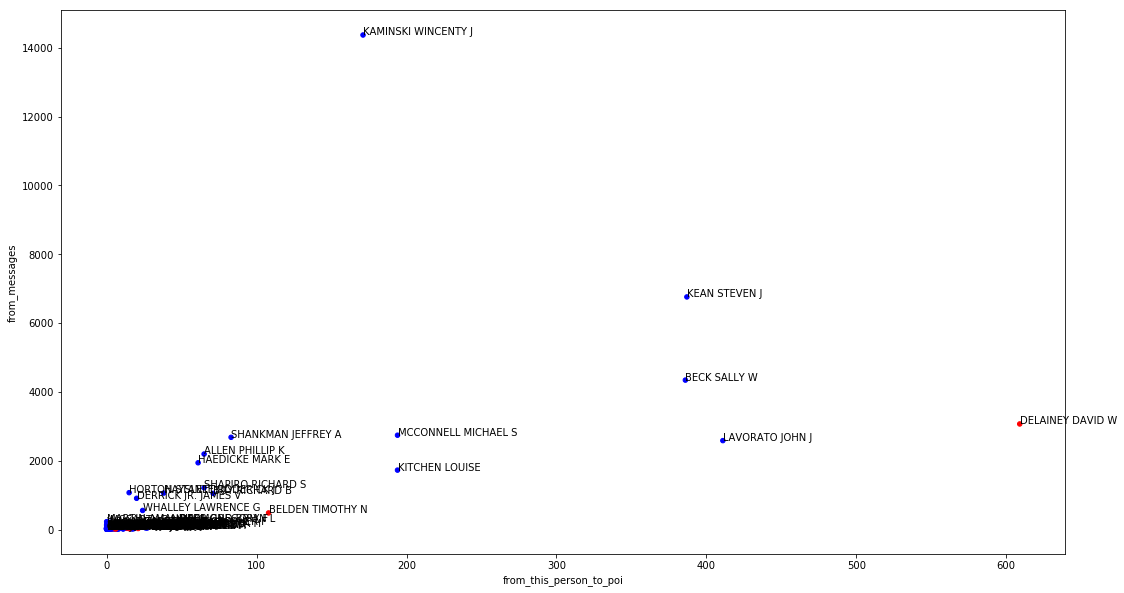

In [28]:
from matplotlib import cm
ax = data.plot.scatter(x="from_this_person_to_poi", y="from_messages", c=[("red" if poi==True else "blue") for poi in data["poi"]],
                       figsize=(18, 10))
label_point(data, "from_this_person_to_poi", "from_messages", ax)

There are employees receiving from or writing to POIs much more emails than most employees. But still, there is no obvious pattern with respect to POIs visible. 

An improvement of the variable set could be to look at the ratio of those two features.

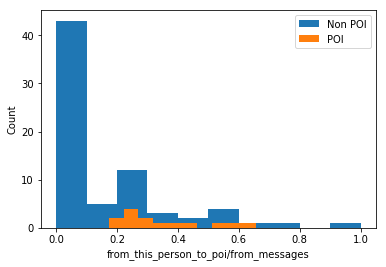

In [29]:
data["ratio_from_to_poi_messages"]=data["from_this_person_to_poi"]/data["from_messages"]
non_pois, pois = data[data["poi"]==False]["ratio_from_to_poi_messages"], data[data["poi"]==True]["ratio_from_to_poi_messages"]
plt.hist(non_pois, stacked=True, label="Non POI")
plt.hist(pois, stacked=True, label="POI")
plt.xlabel("from_this_person_to_poi/from_messages")
plt.ylabel("Count")
plt.legend()
plt.show()


The distribution of the ratio of the features `from_this_person_to_poi` to `from_messages` shows, that Non-POIs frame POIs with regards to that figure.

# Training

In order to be able to test the trained model on a different sample then the training sample, the data has to be split. Since there are only few positive, i.e. POI, data sets in the full data sample, __stratified sampling__ is performed to evenly distribute POIs among the different sample. 

# Validation

To be able to measure the performance more accurate, a method called __cross validation__ is used: the data is divided in 10 stratified samples. 9 of these are used for training and 1 of testing. By altering the sample used for testing ten training and testing cycles are performed.

Validation is important to quantify the preformance of the model on new data. Espacially, since machine learning algorithms are prone to overfitting in which case the performance on the training sample is good but the performance on data new to the algorithm is pretty bad. With validation overfitting problems can be revealed.

## Feature selection in training.

In order to show the feature that are automatically selected by feature selection method I train the best algorithm with the found optimal hyper-parameter set on the complete data set, while the performance has been measured using stratified sampling on a test set after training the model on a training set.

# Results

According to the [scikit learn flow chart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) I decided to test the following three classification ML-algorithms:
1. Support Vector Classification (SVC)
2. k-Nearest Neighbors Classification (kNN)
3. Random Forest Classification (RF)

## Performance Measure
Since the data is dominated by Non-POIs, the accuracy might not be the best measure for the performance, since always assuming false (i.e. the respective employee is a non-POI) already results in an accuracy of 83%. Therefore, I chose to score the models based on the F1 score for the positive , i.e. POI, class. The F1 score is average of precision and recall. 

## Feature selection

To get the final feature selection the feature selection model has to be trained on the data.

In [30]:
from tester import load_classifier_and_data
from poi_id import extract_labels_features, SelectMatchFeatures, SelectFeatureList, log_trans, ImputeOrZero

# Load trained classifier
clf, dataset, feature_list = load_classifier_and_data()

# Extract labels and features
labels, features, _ = extract_labels_features(dataset)
clf.fit(features, labels)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('email_text', Pipeline(steps=[('GetEmailText', SelectMatchFeatures(convert_to_numeric=False, feature_match='word_.*')), ('SelectPercentile', SelectKBest(k=250, score_func=<function chi2 at 0x00000000089129E8>))])), ('subjects', Pipeli...ttan',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'))])

### Reducing the number of word features from emails
First, the number of word features from emails is reduced by using only the `k` best feature with respect toa univariate metric. The parameters `k` (one if [10, 50, 100, 250, 500])and the metric, either ANOVA F-value (`f_classif`) or chi-squared statisitic (`chi2`), are taken as hyper parameters. A naive bayes algorithms is then run on the resulting feature set, with the parameters `alpha` also taken as hyperparameter.

The results are as following.

| Rank | Mean F1 score | F1 Standard deviation | `k` | `score_func` | `alpha` |
| --- | --- | --- | --- | --- | --- |
| 1 | 0.476 | 0.238 | 500 | irrelevant | .5 |
| 2 | 0.459 | 0.091 | 250 | `chi2` | .5 |

The best F1 score was obtained with all words kept, but since the standard variation is much larger for this setting than for the second ranked setting, I chose to keep the third setting.
The best 250 words from the email text used for the next step in the classifier are shown below.

In [31]:
email_text_features = clf.named_steps["union"].transformer_list[0][1].named_steps["GetEmailText"].get_feature_names()
select_email_text_features_idx = clf.named_steps["union"].transformer_list[0][1].named_steps["SelectPercentile"].get_support(indices=True)
#.fit_transform(features, labels)
select_email_text_features =  np.take(email_text_features, select_email_text_features_idx).tolist()
select_email_text_features

[u'word_barri',
 u'word_enjoy',
 u'word_delainey',
 u'word_adjust',
 u'word_contain',
 u'word_profession',
 u'word_chris',
 u'word_communicationsenron',
 u'word_construct',
 u'word_appli',
 u'word_vinc',
 u'word_public',
 u'word_molli',
 u'word_measur',
 u'word_engin',
 u'word_ed',
 u'word_attorney',
 u'word_et',
 u'word_conduct',
 u'word_march',
 u'word_employ',
 u'word_piec',
 u'word_eol',
 u'word_nice',
 u'word_larri',
 u'word_forum',
 u'word_student',
 u'word_comput',
 u'word_luci',
 u'word_print',
 u'word_martin',
 u'word_enw',
 u'word_investor',
 u'word_gari',
 u'word_extern',
 u'word_slide',
 u'word_linda',
 u'word_load',
 u'word_compens',
 u'word_law',
 u'word_hill',
 u'word_dasovich',
 u'word_folder',
 u'word_cindi',
 u'word_design',
 u'word_commiss',
 u'word_peter',
 u'word_flight',
 u'word_crude',
 u'word_sunday',
 u'word_aa',
 u'word_partnership',
 u'word_regul',
 u'word_live',
 u'word_attende',
 u'word_apolog',
 u'word_jan',
 u'word_index',
 u'word_commoditylog',
 u'word_g

Interesstingly, the word `attorney` seems to indicate POIs.

### Reducing the number of subject feauters
The subject features are treated in the same way as the email word features. For the `k` the following settings have been tested: [2, 3, 5, 10, 100, 200]. The top three results are shown below.

| Rank | Mean F1 score | F1 Standard deviation | `k` | `score_func` | `alpha` |
| --- | --- | --- | --- | --- | --- |
| 1 | 0.392 | 0.301 | 100 | `f_classif` | 1 |
| 2 | 0.388 | 0.259 | 100 | `chi2` | 1 |
| 3 | 0.384 | 0.430 | 10 | `chi2` | .5, .8, 1|

Again, since the standard deviation for the second ranked setting is significantly smaller and the mean value is only slightly smaller, I chose the keep this setting for the next steps. The features from email subjects used are listed below.

In [32]:
sub_features = clf.named_steps["union"].transformer_list[1][1].named_steps["GetEmailText"].get_feature_names()
select_sub_features_idx = clf.named_steps["union"].transformer_list[1][1].named_steps["SelectPercentile"].get_support(indices=True)
#.fit_transform(features, labels)
select_sub_features =  np.take(sub_features, select_sub_features_idx).tolist()
select_sub_features

[u'sub_from_follow up',
 u'sub_to_2000 ena offsite',
 u'sub_from_hiring practices for summer interns',
 u'sub_from_cgas',
 u'sub_from_congrats',
 u'sub_from_summer internship',
 u'sub_to_netco',
 u'sub_from_houston we have a problem',
 u'sub_to_enrononline executive summary  for june 04 2001',
 u'sub_to_ene friday peer group report',
 u'sub_to_enrononline executive summary for december 12 2000',
 u'sub_to_ena management committee',
 u'sub_to_expenditures with minoritywomen owned business enterprises through',
 u'sub_from_draft of organizational announcement',
 u'sub_from_your approval is requested',
 u'sub_to_online trading simulation',
 u'sub_from_egm business presentation',
 u'sub_to_briefing paper fercs june 19 westwide price mitigation order',
 u'sub_from_followup',
 u'sub_from_global risk management operations',
 u'sub_from_weekly report',
 u'sub_to_enron mentions',
 u'sub_from_organizational announcement',
 u'sub_to_government affairs organizational changes',
 u'sub_from_enron me

Financials features are used as provided excepts thos whith many missing values as stated above.

In [33]:
fin_features = clf.named_steps["union"].transformer_list[2][1].named_steps["ConvertToVector"].get_feature_names()
fin_features

['bonus',
 'exercised_stock_options',
 'expenses',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'total_payments',
 'total_stock_value']

Counting email features are used as provided.

In [43]:
email_features = clf.named_steps["union"].transformer_list[3][1].named_steps["ConvertToVector"].get_feature_names()
email_features

['from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'to_messages']

## Feature scaling and transformation

After extracting the features from the dictionary, missing valuesin the financial features are replaced by zero. Than, email counting and financial features are transformed to a logarithmic scale. From the subject features the selected 100 features with the best Chi square stats for the training sample are selected. The same is done for the email word features, only that 250 features are used. In addition to that, it is tested whether a chained estimator is helpful, i.e. if the performance increases if a separate naive bayes classifier is run email words and subjects features and only the result of this estimator is forwarded as a single feature to the final classifiert. 

After that all the features are combined scaled to mean 0 and unit variance. 

## Feature union selection

After the reduction of features, it is tested which combination of group of features, email words, subject lines, financial and email count, give the best results. I also tested whether the chained naive bayes classifier for subject and email word features increaeses the performance. The following flow charts gives an overview about the feature selection and feature union processesing.

![Flow chart feature selection](img/Flow chart feature selection.png)

I tested every possible combination of the four subset of features giving a total of $3 \times 3 \times 2 \times 2 -1=35$ (1 is subtracted because using no features at all is senseless) combinations with the default settings defined by the scikit learn package of each classifier.

The best combination of features for each classifier are given in the following table. NB indicated that the feature was used after being put through a Naive Bayes classifier.

| Classifier | Email word features | Subject features | Financial feauters | Email count features | Mean F1-Score |
| --- | --- | --- | --- | --- | --- |
| SVC | No | Yes | Yes | Yes  | 0.428 (std: 0.341) |
| kNN | No | Yes (NB) | No | Yes | 0.412 (std: 0.172) |
| RF | No | Yes | Yes | Yes | 0.252 (std: 0.308) |

For all classifiers, the best combination neglects the email word features, therefore email word features are neglected in the following. 
Except for the kNN, which uses only the output from the naive bayes classifier on the subject feature all classifiers suffer from overtraining as it is obvious from the large standard deviations.
The final decision on the final feature subset has to be post-poned after hyper-parameter tuning.

## Hyper-parameter tuning and model selection

For each of the three selected classifiers, different settings for hyper parameters are tested. Hyper parameters have to be tuned in order
- to obtain the best possible results and 
- to reduce effects of overfitting.
Here, a grid search probing many different parameter sets has been implemented. The following parameters are checked for the various classifiers.

__RF__

| Parameter | Values |
| --- | --- |
| `min_samples_leaf` | 1, 2, 4 |
| `n_estimators` | 5, 10, 20 |
| `min_samples_split` | 2, 4, 6 |

__SVC__

| Parameter | Values |
| --- | --- |
| `class_weight` | None, `'balanced'` |
| `kernel` | `'rbf'`, `'sigmoid'`, `'linear'`  |
| `C` | .2, .5, .8, 1 |

__kNN__

| Parameter | Values |
| --- | --- |
| `n_neighbors` | 1, 3, 5 |
| `metric` | `'manhattan'`,  `'minkowski'` |
| `weights` | `'uniform'`, `'distance'` |

In addition to this all subsets of features are probed including the chained naive bayes classifier for the subject features.

The results for each classifier are shown in this table.

| Classifier | Subject | Financial | Email count | Parameter 1 | Setting | Parameter 2 | Setting | Parameter 3 | Setting | F1 Score
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| RF | Yes | No | No | `min_samples_leaf` | 1  | `n_estimators` | 20 | `min_samples_split` | 2 | 0.426 (std: 0.442) |
| SVC | No | No | Yes | `class_weight` | `"balanced"` | `kernel` | `"linear"` | `C` | 0.8, 1.0 | 0.492 (std: 0.107) |
| kNN | Yes | No | Yes/No | `n_neighbors` | 3 | `metric` | `"manhattan"` | `weights` | `"distance"` | 0.521 (std: 0.388) |

The optimal result is achieved by the kNN classifier with subject features with or without email count features. A little smaller score but with much smaller standard deviation is achieved by the SVC using only the email count features.

The following table gives the result for precision, recall and F1 score for all classes (POI, non-POI) for the best found kNN classifier.

| class | precision |    recall |  f1-score |   support |
| --- | --- | --- | --- | --- |
| False | 0.91 | 0.96 | 0.93 | 72 |
| True | 0.70 | 0.50 | 0.58 | 14 |
|__avg / total__ | 0.87 | 0.88 | 0.88 | 86

At average 70% of the employees classified as POIs are POIs indeed and 50% of POIs are found. The results in an F1 score of 58%. 

The accuracy of this classifier is 88.4 %.

## Effect of the new features
The email word features extracted from the email texts are neglected by all classifiers in the optimal found parameter setting.

The subject feature are used by the kNN algorithm. Without this features the F1 score would be 0.335 (std: 0.248).

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score
np.random.seed(3)
pred = cross_val_predict(clf, features, labels, cv=10)

print classification_report(labels, pred)
print "Accuracy: ", accuracy_score(labels, pred)

             precision    recall  f1-score   support

      False       0.87      0.99      0.92        72
       True       0.75      0.21      0.33        14

avg / total       0.85      0.86      0.83        86

Accuracy:  0.860465116279


## Other ideas

I had some hard time thinking about whether it is valid to use a feature like `from_poi_to_this_person` in training. These features include information about other POIs in the sample but not for the current data set. Therefore, I think it is valid. These features evolve from network analyses. I might be interesting to look deeper into the networks of Enron employees: How strong a connections between people e.g. based on the number of emails exchanged. A good starting point might be [Jure Leskovec, Kevin J. Lang, Anirban Dasgupta, Michael W. Mahoney](http://arxiv.org/abs/0810.1355).